In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as spss
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import arviz as az


plt.style.use("seaborn-ticks")

column_types={"time":"float16", #declaring types to go easy on RAM
              "conf":"int8",
              "average":"float32",
              "participant":"category",
              "expdResp":"category"
        }


# Extracting slopes from EMG centered on EMG onset

In [26]:
epochPath = "../../data/EMG/Epochs/"
list_dir = os.listdir(epochPath)
list_raw, list_parameters = [],[]
start, duration = int(.1*2048), int(.03*2048) #starts 100 ms after begining of signal ends at 130ms after signal
end = start+duration
for f in list_dir:
    if 'partie 2' not in f.split('_')[0]:
        print(f.split('_')[0])
        raw_ = pd.read_table(epochPath+f, header=0, sep=',',skipinitialspace=True,
                     usecols=["epoch","time","condition","EMG_L","EMG_R"],
                     dtype=column_types)
        slope = []
        for epoch, epoch_dat in raw_.groupby('epoch'):
            rep = epoch_dat.condition.unique()[0].split('/')[1]
            if rep == "G":
                raw_.loc[raw_.epoch == epoch, "R_channel"] = np.abs(epoch_dat["EMG_L"]) # Taking abs value
            else : 
                raw_.loc[raw_.epoch == epoch, "R_channel"] = np.abs(epoch_dat["EMG_R"])
            linreg = spss.linregress(x=raw_.loc[raw_.epoch == epoch, "time"][start:end]*1000, y=np.cumsum(np.abs(raw_.loc[raw_.epoch == epoch, "R_channel"][start:end])))
            slope.append(linreg[0])
        del raw_['EMG_L']
        del raw_['EMG_R']
        raw_['SAT'], raw_['direction'], raw_['p_right'] = \
               zip(*raw_['condition'].map(lambda y: y.split('/')))
        del raw_['condition']
        raw_["direction"]= raw_.apply(lambda row: "right" if row['direction'] == "D" else "left", axis=1)
        raw_["Validity"] = raw_.apply(lambda row : "valid" if row['direction'] == "right" and row['p_right'] == '70' else 
                           ("valid" if row['direction'] == "left" and row['p_right'] == '30' else 
                           ("even" if row['p_right'] == '50' else "invalid" )), axis = 1)
        #################### Extracting slope and baseline
        parameters = raw_.groupby(['epoch','SAT','Validity']).mean().reset_index()
        parameters['slope'] = slope
        parameters['participant'] = f.split('_')[0]
        list_parameters.append(parameters)
        #####################" Average time cours of participant"
        raw_ = raw_.groupby(['Validity','SAT','time']).R_channel.mean()
        raw_ = raw_.reset_index()
        raw_['participant'] = f.split('_')[0]
        list_raw.append(raw_)

df_EMG_averages_tc = pd.concat(list_raw, ignore_index=True)
df_EMG_parameters = pd.concat(list_parameters, ignore_index=True)

df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['accuracy','speed'])

df_EMG_averages_tc.to_csv("EMG_tc_EMGc.csv")
df_EMG_parameters.to_csv("EMG_slopes.csv")

S20.csv
S15.csv
S11.csv
S3.csv
S19.csv
S8.csv
S13.csv
S18.csv
S9.csv
S12.csv
S10.csv
S14.csv
S17.csv
S2.csv
S16.csv
S7.csv


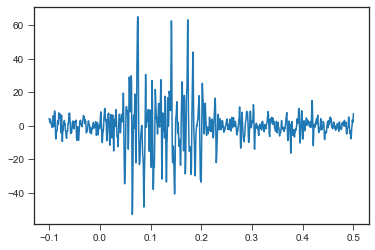

In [93]:
plt.plot(epoch_dat.time, epoch_dat.EMG_L)

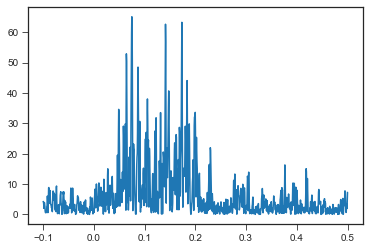

In [94]:
plt.plot(epoch_dat.time, np.abs(epoch_dat.EMG_L))

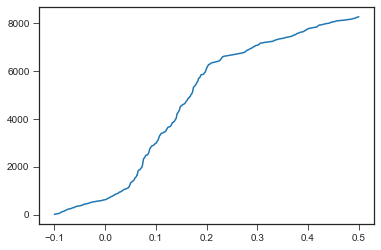

In [95]:
plt.plot(epoch_dat.time, np.cumsum(np.abs(epoch_dat.EMG_L)))

## Plotting mean time course of EMG

In [2]:
df_EMG_averages_tc_EMGc = pd.read_csv("EMG_tc_EMGc.csv")
df_EMG_parameters = pd.read_csv("EMG_slopes.csv")

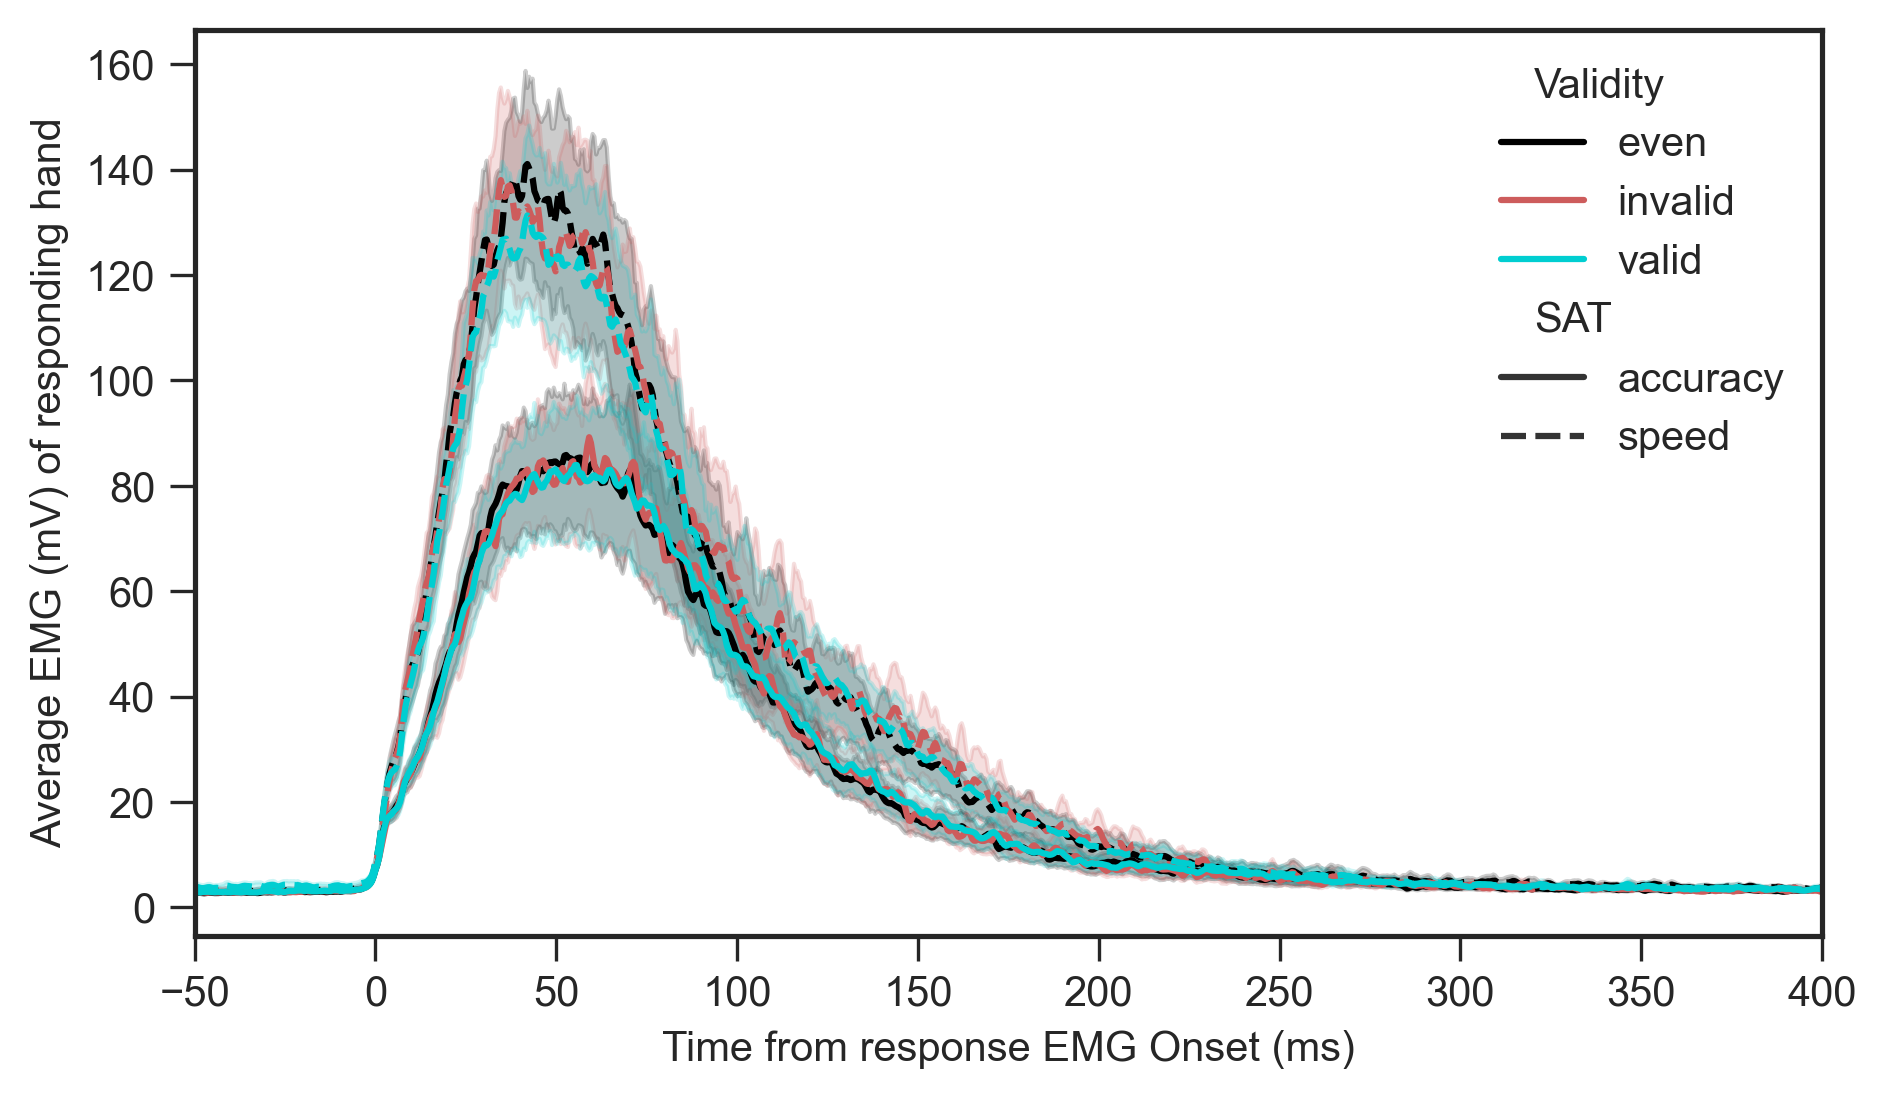

In [30]:

fig, ax = plt.subplots(figsize=[7, 4],dpi=300)
grp_avrg = df_EMG_averages_tc_EMGc.groupby(['participant','time','Validity','SAT']).R_channel.mean().reset_index()
grp_avrg.time = grp_avrg.time*1000
sns.lineplot(data=grp_avrg, x='time', y="R_channel", hue="Validity",ci=65, palette=['k','indianred','darkturquoise'], style="SAT",ax=ax,legend=True)
plt.xlim(-50, 400)
plt.ylabel('Average EMG (mV) of responding hand')
plt.xlabel('Time from response EMG Onset (ms)')

#axins = ax.inset_axes([0.6, 0.1, .4, .4])
#sns.lineplot(data=grp_avrg[grp_avrg.time <0], x='time', y="R_channel", hue="Validity",ci=False, palette=['k','indianred','royalblue'], style="SAT",ax=axins,legend=False)
# sub region of the original image
#x1, x2, y1, y2 = -50, 0, 2, 6
#axins.set_xlim(x1, x2)
#axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
#axins.set_xlabel('')
#axins.set_ylabel('')

#ax.indicate_inset_zoom(axins)

plt.show()

# LMM

<AxesSubplot:xlabel='slope', ylabel='Density'>

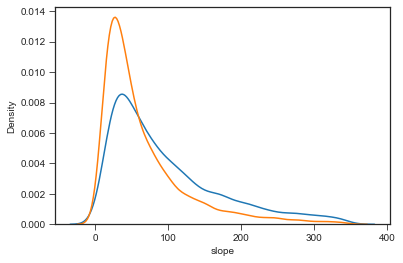

In [35]:
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.slope) < df_EMG_parameters.slope.std()*3)&(df_EMG_parameters.SAT == "speed")].slope)
sns.kdeplot(df_EMG_parameters[(np.abs(df_EMG_parameters.slope) < df_EMG_parameters.slope.std()*3)&(df_EMG_parameters.SAT == "accuracy")].slope)

Skewed (like MT) but not really log...

<AxesSubplot:xlabel='slope', ylabel='Density'>

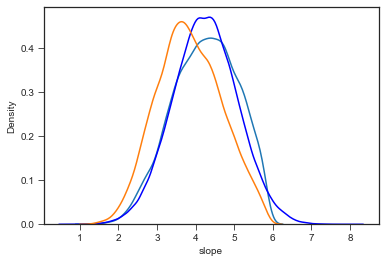

In [36]:
logslopes = np.log(df_EMG_parameters[(np.abs(df_EMG_parameters.slope) < df_EMG_parameters.slope.std()*3)&(df_EMG_parameters.SAT == "speed")].slope)
sns.kdeplot(logslopes)
sns.kdeplot(np.random.normal(logslopes.mean(), logslopes.std(),100000),color='b')
sns.kdeplot(np.log(df_EMG_parameters[(np.abs(df_EMG_parameters.slope) < df_EMG_parameters.slope.std()*3)&(df_EMG_parameters.SAT == "accuracy")].slope))

OK check residuals

In [201]:
LME = pystan.StanModel(file='MixedModels/LME.stan')
with open('MixedModels/LME.pkl', 'wb') as f:
    pickle.dump(LME, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3535856e449ab2df75cb057031a2ad56 NOW.


In [10]:
LMEdata = df_EMG_parameters[(np.abs(df_EMG_parameters.slope) < df_EMG_parameters.slope.std()*3)].copy()
print(LMEdata.head())
LMEdata.slope = np.log(LMEdata.slope)
LMEdata['SAT'] = LMEdata.apply(lambda row: 0 if row['SAT'] == "speed" else 1, axis=1)
LMEdata['Validity'] = LMEdata.apply(lambda row: -0.5 if row['valid'] == 'invalid' else (
        0.5 if row['slope'] == 'valid' else 0), axis=1)
LMEdata['participant'] = LMEdata.participant.replace(LMEdata.participant.unique(), np.arange(len(LMEdata.participant.unique()))+1) 
LMEdata = LMEdata[["slope","participant",
                   "SAT","Validity"]]
print(LMEdata.head())


   Unnamed: 0  epoch       SAT    valid  time  R_channel         slope  \
0           0      0  accuracy     even   0.2   6.687230  20757.485083   
1           1      2  accuracy  invalid   0.2   8.514578  32482.714870   
2           2      4  accuracy    valid   0.2   7.093187  38249.020267   
3           3      6  accuracy     even   0.2  14.409254  41774.848565   
4           4      8  accuracy    valid   0.2   7.783182  51621.920116   

    intercept participant Validity  
0  -48.453011     S20.csv     even  
1  -64.450038     S20.csv  invalid  
2 -111.973042     S20.csv    valid  
3 -180.929405     S20.csv     even  
4 -187.127718     S20.csv    valid  
       slope  participant  SAT  Validity
0   9.940662            1    1       0.0
1  10.388463            1    1      -0.5
2  10.551873            1    1       0.0
3  10.640050            1    1       0.0
4  10.851702            1    1       0.0


In [11]:
import pickle
import patsy
LME = pickle.load(open('MixedModels/LME.pkl', 'rb'))

model_name = "slope_fit"

fixeff_form = "1+SAT+Validity+SAT:Validity"#Fixed effects formula
raneff_form = fixeff_form #Random effects formula
fixeff = np.asarray(patsy.dmatrix(fixeff_form, LMEdata)) #FE design matrix
raneff = np.asarray(patsy.dmatrix(raneff_form, LMEdata)) #RE design matrix
prior_intercept = np.asarray([10,4])#prior for intercept, mu and sigma
priors_mu = np.repeat(0, 3) #Priors on mu for FE
priors_sigma =  np.repeat(4, 3) # priors on sigma for FE
priors_raneff = [0, 4] #Priors on RE
prior_sd = [0, 4] #priors on residual sigma

LME_data = dict(
    N = len(LMEdata),
    P = fixeff.shape[-1], #number of pop level effects
    J = len(LMEdata.participant.unique()),
    n_u = raneff.shape[-1],
    subj = LMEdata.participant,
    X = fixeff,
    Z_u = raneff,
    y = LMEdata.slope.values,
    p_intercept = prior_intercept, p_sd = prior_sd, p_fmu = priors_mu, p_fsigma = priors_sigma, p_r = priors_raneff,
    logT = 1
)

if os.path.exists("MixedModels/FittedModels/%s.pkl"%model_name):
    with open("MixedModels/FittedModels/%s.pkl"%model_name, "rb") as f:
        data_dict = pickle.load(f)
    fit = data_dict['fit']

else:
    fit = LME.sampling(data=LME_data, iter=2000, chains=6, n_jobs=6, 
                              warmup = 1000,thin=2)
    with open("MixedModels/FittedModels/%s.pkl"%model_name, "wb") as f:
        pickle.dump({'model' : LME, 'fit' : fit}, f, protocol=-1)

slope_fit_az = az.from_pystan(posterior=fit, posterior_predictive='y_hat', observed_data="y", log_likelihood='log_lik',
                                       coords={'b': fixeff_form.split('+')[1:]}, dims={'beta': ['b']})

In [31]:
def plot_resid(fit):
    from scipy.stats import probplot
    observed = fit.observed_data.y.values 
    predicted = np.mean(fit.posterior_predictive.y_hat.values, axis=(0,1)) 
    residuals = observed - predicted
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=[15,7])
    probplot(residuals, dist="norm", plot=ax1)
    ax2.plot(np.sort(observed, kind='mergesort'), residuals, '.')
    ax2.plot([observed.min(), observed.max()],[0,0],linestyle='--', color='r')

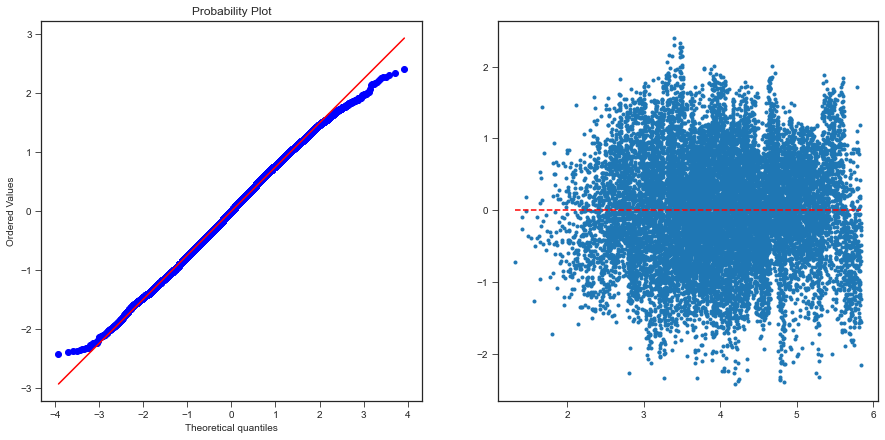

In [32]:
plot_resid(slope_fit)

/home/gabriel/anaconda3/envs/pystan/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(


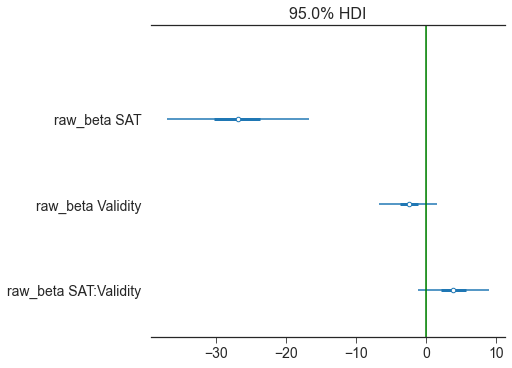

In [33]:
g = az.plot_forest(slope_fit, var_names="raw_beta", credible_interval=0.95, 
                   combined=True, figsize=(7,5), rope=(0,0))
plt.vlines(0, -1, 10, 'g')
plt.show()


In [36]:
az.summary(slope_fit, var_names=["raw_intercept","raw_beta"], round_to=2, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
raw_intercept,73.06,7.99,58.79,90.33,0.27,0.19,878.90,878.90,868.58,1914.35,1.00
raw_beta[0],-27.01,5.13,-36.98,-16.64,0.17,0.12,905.17,905.17,893.79,1682.66,1.01
raw_beta[1],-2.43,2.08,-6.64,1.59,0.03,0.02,4290.17,3586.21,4335.09,4272.32,1.00
raw_beta[2],3.97,2.64,-1.18,9.01,0.04,0.03,4557.17,3782.60,4678.53,3863.84,1.00


Plotting the data

In [20]:
data = pd.read_csv('EMG_slopes.csv')

LMEdata = data[np.abs(data.slope) < data.slope.std()*3].copy()
print(LMEdata.head())
LMEdata.slope = np.log(LMEdata.slope)
LMEdata['SAT'] = LMEdata.apply(lambda row: 0 if row['SAT'] == "speed" else 1, axis=1)
LMEdata['Validity'] = LMEdata.apply(lambda row: -0.5 if row['Validity'] == "invalid" else (
        0.5 if row['Validity'] == 'valid' else 0), axis=1)
LMEdata['participant'] = LMEdata.participant.replace(LMEdata.participant.unique(), np.arange(len(LMEdata.participant.unique()))+1) 
LMEdata = LMEdata[["slope","participant",
                   "SAT","Validity"]]
print(LMEdata.head())



   Unnamed: 0  epoch       SAT Validity  time  R_channel      slope  \
0           0      0  accuracy     even   0.2   6.687230  20.757485   
1           1      2  accuracy  invalid   0.2   8.514578  32.482715   
2           2      4  accuracy    valid   0.2   7.093187  38.249020   
3           3      6  accuracy     even   0.2  14.409254  41.774849   
4           4      8  accuracy    valid   0.2   7.783182  51.621920   

  participant  
0     S20.csv  
1     S20.csv  
2     S20.csv  
3     S20.csv  
4     S20.csv  
      slope  participant  SAT  Validity
0  3.032907            1    1       0.0
1  3.480708            1    1      -0.5
2  3.644118            1    1       0.5
3  3.732294            1    1       0.0
4  3.943946            1    1       0.5


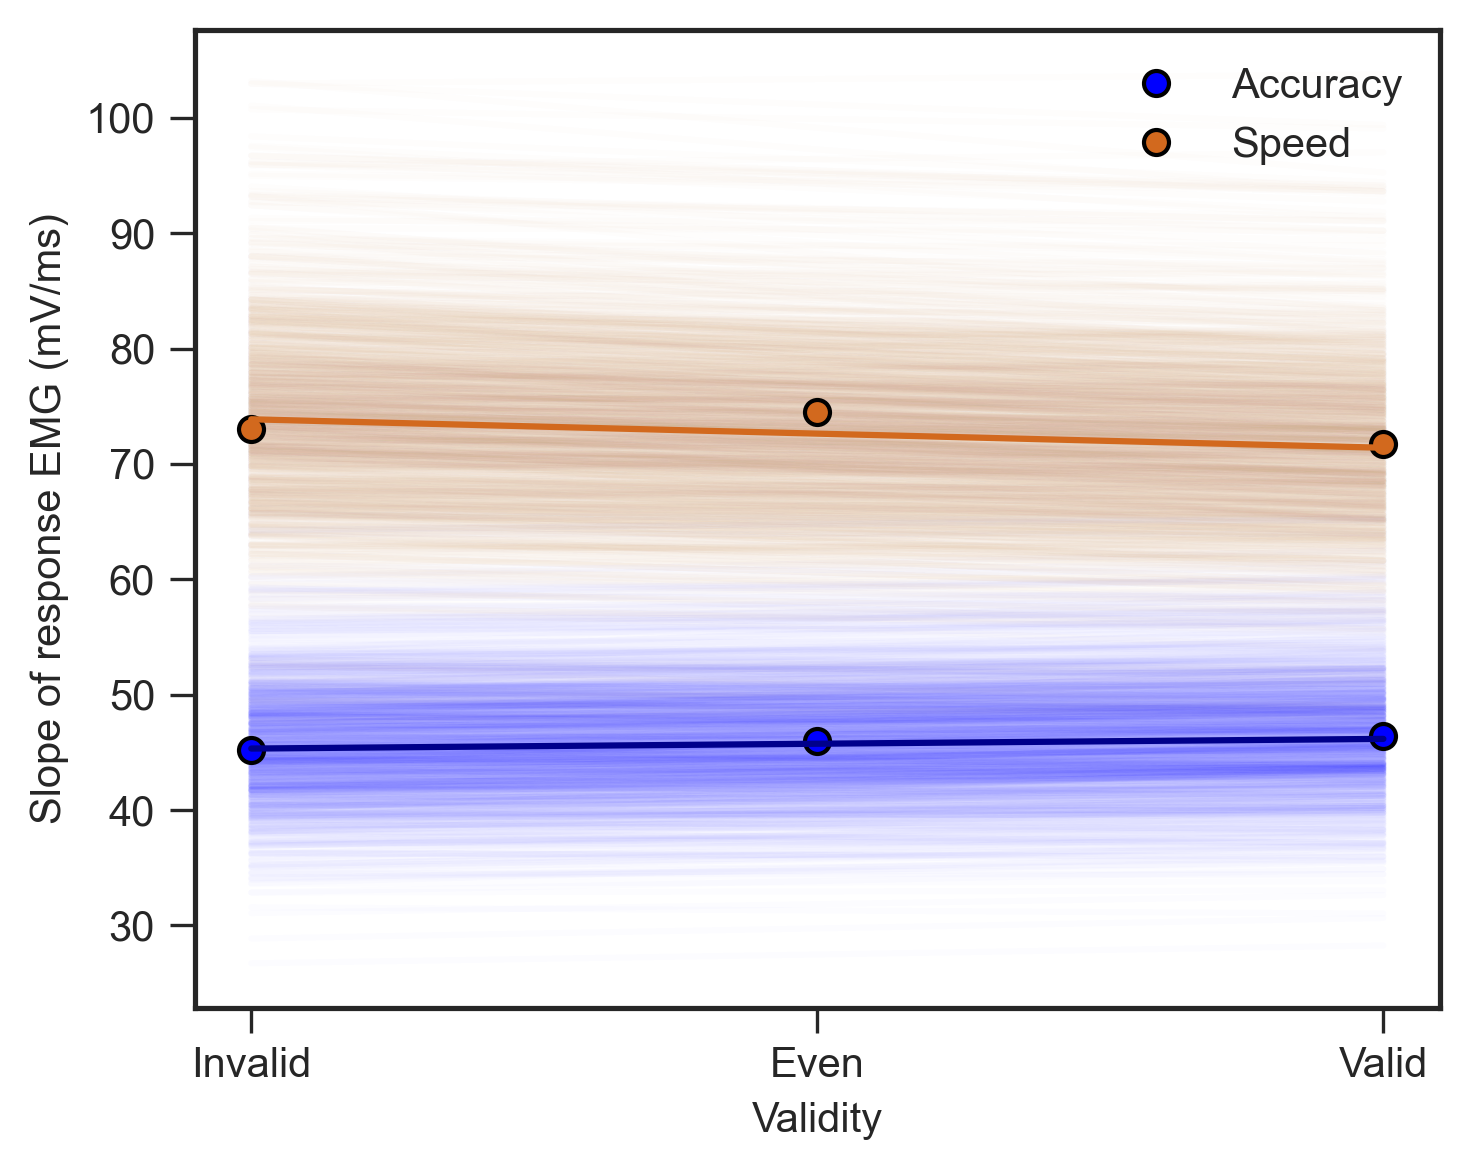

In [29]:
from scipy.special import expit
from random import sample

fig, ax = plt.subplots(1,1, sharey=False, figsize=(5,4), sharex=False, dpi=300)

display_range = x = validity = np.asarray([-0.5, 0, .5])

fixeff_form = "1+SAT+Validity+SAT:Validity"#Fixed effects formula
param_dict = {val : idx for idx, val in enumerate(fixeff_form.split('+')[1:])} 
fit = slope_fit
j = 0
alpha, beta = fit.posterior.alpha, fit.posterior.beta
samples,chains = fit.posterior.draw.values,fit.posterior.chain.values
for z in np.arange(1):
    for d in sample(list(samples),1000):
        c = np.random.choice(chains)
        intercept, bSAT, bValidity, bSATValidity =  \
            alpha.sel(draw=d, chain=c).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT"]).values,\
            beta.sel(draw=d, chain=c, beta_dim_0=param_dict["Validity"]).values,\
            beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:Validity"]).values
        ax.plot(display_range, np.exp(intercept+bSAT*0+validity*bValidity+bSATValidity*validity*0), color="chocolate", alpha=.01)
        ax.plot(display_range, np.exp(intercept+bSAT*1+validity*bValidity+bSATValidity*validity*1), color="blue", alpha=.01)
    intercept, bSAT, bValidity, bSATValidity =  \
        alpha.mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT"]).mean(axis=(0,1)).values,\
        beta.sel(beta_dim_0=param_dict["Validity"]).mean(axis=(0,1)).values, \
        beta.sel(beta_dim_0=param_dict["SAT:Validity"]).mean(axis=(0,1)).values

    ax.set_ylabel('Slope of response EMG (mV/ms)')
    data = LMEdata.copy()
    data['SAT'] = data.SAT.replace([1,0], ['accuracy','speed'])
    F1 = data[(data.SAT=="accuracy")].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
    F2 = data[(data.SAT=="speed")].groupby(['participant','Validity']).mean().groupby('Validity') #Strong force only
    ax.plot( x, np.exp(F1.slope.mean().values),'o',color="blue", markeredgecolor ="k", label="Accuracy")
    ax.plot( x, np.exp(F2.slope.mean().values),'o',color="chocolate", markeredgecolor ="k", label="Speed")
    ax.plot(display_range, np.exp(intercept+bSAT*0+validity*bValidity+bSATValidity*validity*0), color="chocolate")
    ax.plot(display_range,np.exp(intercept+bSAT*1+validity*bValidity+bSATValidity*validity*1), color="darkblue")
    ax.set_xlabel('Validity')
    ax.set_xticks([-0.5,0,0.5])
    ax.set_xticklabels(['Invalid','Even','Valid'])
    ax.legend(loc=1)
plt.tight_layout()
plt.show()